In [1]:
using LaTeXStrings;
using Plots,CSV,DataFrames;

In [2]:
# pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
#     ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
#     bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);
gr(frame=:box, minorticks=5, size=(500,350),titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [3]:
include("./libs/constants.jl");

In [4]:
#https://github.com/fkguo/IMinuit.jl/blob/master/src/Data.jl
# check whether the data are valid for a fit
function check_data(xdata, ydata, errdata)
    if any(ismissing, xdata) || any(ismissing, ydata) || any(ismissing, errdata)
        error("Error: Data contain `missing` values.")
    end
    if any(isinf, xdata) || any(isinf, ydata) || any(isnan, xdata) || any(isnan, ydata) || any(isnan, errdata)
        error("Error: Data contain `Inf` or `NaN` values.")
    end
    if any(iszero, errdata)
        error("Error: Data contain 0 in the errors.")
    end
end

"""
    Data(x::T, y::T, err::T) where {T<:Vector{Real}}
    Data(df::DataFrame)
Fields: `x, y, err, ndata`
This defines a type for data with three columns:` x, y, err`; `ndata` is the number of data rows.
Different `Data` sets can be concatenated as `vcat(dat1, dat2, dat3)`.
Only symmetric errors (of `y`) are supported.
"""
struct Data
    x::Vector{Float64}
    y::Vector{Float64}
    err::Vector{Float64}
    ndata::Int
    function Data(x, y, err) # Data(x::Vector{T}, y::Vector{T}, err::Vector{T}) where {T<:Real}
        check_data(x, y, err)
        ndata = length(x)
        new(x, y, err, ndata)
    end
end

Data(df::DataFrame) = Data(df[:,1], df[:,2], df[:,3])

import Base.vcat, Base.getindex
vcat(dat1::Data, dat2::Data) = Data(vcat(dat1.x, dat2.x), vcat(dat1.y, dat2.y), vcat(dat1.err, dat2.err))
vcat(dat1::Data, dat...) = reduce(vcat, [dat1, dat...])
getindex(data::Data, in) = Data(map(x-> getindex(x, in), (data.x, data.y, data.err))...)

"""
    @plt_data(data, kws...)
    @plt_data!(data, kws...)
Convenient mascros to make an errorbar plot of the `data`; all combinations of
keyword settings for `scatter` in `Plots` can be used for the optional arguments `kws...`
"""
macro plt_data(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end
macro plt_data!(data, kws...)
    _plt = quote
        if isempty($kws)
            Plots.scatter!($data.x, $data.y, yerror = $data.err,
            xlab = "x", ylab = "y", label = "Data")
        else
            Plots.scatter!($data.x, $data.y, yerror = $data.err; $(kws...) )
        end
    end
    return esc(_plt)
end

@doc raw"""
    chisq(dist::Function, data, par; fitrange = ())
defines the ``\chi^2`` function: `fun` the function to be fitted to the data given by `data`.
The parameters are collected into `par`, given as an array or a tuple.
* `data` can be either given as the `Data` type, or of the form `(xdata, ydata [, err])`.
If no `err` is given explicitly, the errors are assumed to be 1 for all data points.
* `fitrange`: default to the whole data set; may given as, e.g., `2:10`,
which means only fitting to the 2nd to the 10th data points.
"""
function chisq(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
    end
    return res
end
# function chisq(dist::Function, data::Data, par::Tuple; fitrange = ())
#     fitrange = (isempty(fitrange) && 1:data.ndata)
#     res = 0.0
#     @simd for i = fitrange
#         @inbounds res += ( (data.y[i]- dist(data.x[i], par))/data.err[i] )^2
#     end
#     return res
# end
function chisq(dist::Function, data, par; fitrange = ())
    _x = data[1]; _y = data[2]
    _n = length(_x)
    _err = (length(data) == 2 ? ones(_n) : data[3])
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    # __dist__(x, par) = (length(func_argnames(dist)) > 2 ? dist(x, par...) : dist(x, par) )
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( (_y[i]- dist(_x[i], par))/_err[i] )^2
    end
    return res
end

"""
    @plt_best(dist, fit, data, kws...)
    @plt_best!(dist, fit, data, kws...)
A convenient macro for comparing the best-fit result with the data; all combinations of
keyword settings for `plot` in `Plots` can be used for the optional arguments `kws...`
The ordering of `dist`, `fit`, and `data` does not matter.
"""
macro plt_best(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

macro plt_best!(dist, fit, data, kws...)
    _expr = quote
        _arr = [$dist, $fit, $data]
        _fit = _arr[findfirst(x->typeof(x) <:AbstractFit, _arr)]
        _dist = _arr[findfirst(x->typeof(x) <:Function, _arr)]
        _data = _arr[findfirst(x->typeof(x) <:Data, _arr)]

        _npts = 100
        _paras = args(_fit)
        _dis(x) = (typeof(_fit) == ArrayFit ? _dist(x, _paras) : _dist(x, _paras...) )
        _xrange = _data.x
        _wv = LinRange(_xrange[1], _xrange[end], _npts)

        Plots.scatter!($data.x, $data.y, yerror = $data.err, label = "Data")
        if isempty($kws)
            Plots.plot!(_wv, _dis.(_wv), xlab = "x", ylab = "y", label = "Best fit", lw = 1.5 )
        else
            Plots.plot!(_wv, _dis.(_wv); $(kws...)  )
        end
    end
    esc( _expr )
end

@plt_best! (macro with 1 method)

In [5]:
let 
    data_ddπ_sub_df = DataFrame(CSV.File("./data/ddpi_sub_du.csv", header = ["x", "y"]));
    len=length(data_ddπ_sub_df.x)
    len1=Int64(len/3)
    xv=[3.8731+0.0002*(i-1) for i in 1:20]
    yv=[data_ddπ_sub_df.y[3*(i-1)+2] for i in 1:len1]
    wv=[abs(data_ddπ_sub_df.y[3*(i-1)+1]-data_ddπ_sub_df.y[3*(i-1)+3])/2 for i in 1:len1]
    global const data_ddπ_sub=Data(xv,yv,wv);
    nothing
end

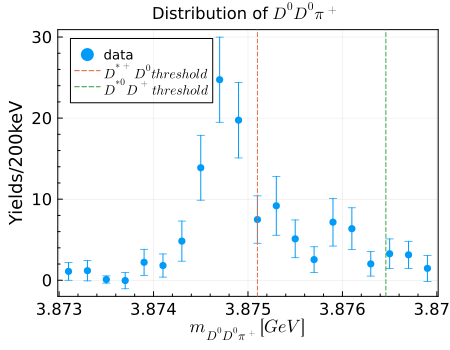

In [6]:
@plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = "Yields/200keV" label = "data" size = (450, 350)
vline!([mDn + mDsc], ls = :dash, label = L"D^{*+}D^0 threshold")
vline!([mDc + mDsn], ls = :dash, label = L"D^{*0}D^+ threshold")

In [9]:
df_fit1_rs1=DataFrame(CSV.File("./output/fit1_rs1.csv", header = ["x", "y"]));
df_fit1_rs2=DataFrame(CSV.File("./output/fit1_rs2.csv", header = ["x", "y"]));
df_fit2=DataFrame(CSV.File("./output/fit2.csv", header = ["x", "y"]));
df_bestfit2=DataFrame(CSV.File("./output/bestfit2.csv", header = ["x", "y"]));
df_fit3=DataFrame(CSV.File("./output/fit3.csv", header = ["x", "y"]));

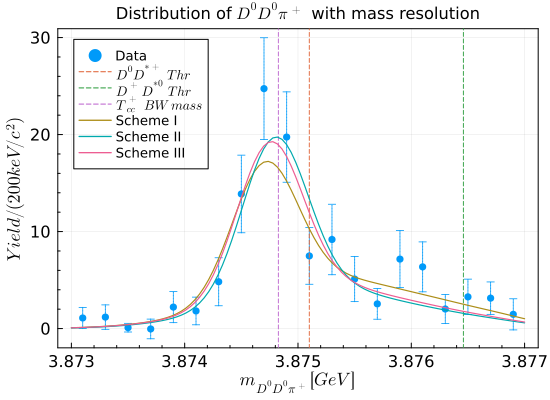

In [8]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with mass resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(200keV/c^2)" ls=:dot label = "Data" size = (550, 400) legend = :topleft
    vline!([mDn + mDsc], linestyle = :dash, label = L"D^0D^{*+}\ Thr")
    vline!([mDc + mDsn], ls = :dash, label = L"D^+D^{*0}\ Thr")
    vline!([mDn + mDsc-273e-6], ls = :dash, label = L"T_{cc}^+\ BW\ mass")
    plot!(Ev,df_fit1_rs1.y,lw=1.2,label="Scheme I")
#     plot!(Ev,df_fit1_rs2.y,ls=:dot,label="Scheme II:RSII")
    plot!(Ev,df_fit2.y,lw=1.2,label="Scheme II")
    plot!(Ev,df_fit3.y,lw=1.2,label="Scheme III")
#     savefig("./images/baselinefitting.pdf")
end

In [11]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with mass resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(200keV/c^2)" ls=:dot label = "Data" size = (550, 400) legend = :topleft
    vline!([mDn + mDsc], linestyle = :dash, label = L"D^0D^{*+}\ Thr")
    vline!([mDc + mDsn], ls = :dash, label = L"D^+D^{*0}\ Thr")
    vline!([mDn + mDsc-273e-6], ls = :dash, label = L"T_{cc}^+\ BW\ mass")
    plot!(Ev,df_fit1_rs1.y,lw=1.2,label="Scheme I")
#     plot!(Ev,df_fit1_rs2.y,ls=:dot,label="Scheme II:RSII")
    plot!(Ev,df_bestfit2.y,lw=1.2,label="Scheme II")
    plot!(Ev,df_fit3.y,lw=1.2,label="Scheme III")
    savefig("./images/bestfitting.pdf")
end

"/Users/qiulin/Nutstore Files/Nutstore/Projects/gitrepos/Tcc/LSE/images/bestfitting.pdf"

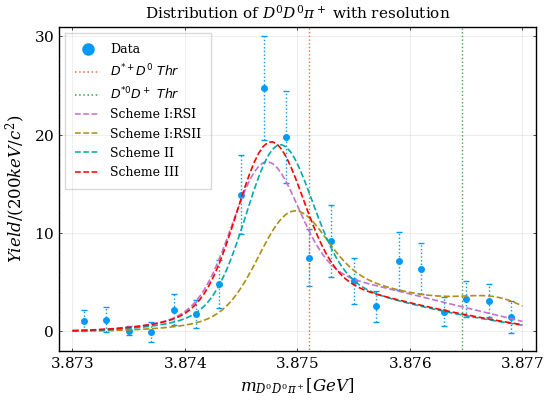

In [14]:
let
    Ev = range(3.873, 3.877, 100)
    @plt_data data_ddπ_sub title = L"Distribution of $D^0D^0\pi^+$ with resolution" xlabel = L"m_{D^0D^0\pi^+}[GeV]" ylabel = L"Yield/(200keV/c^2)" ls=:dot label = "Data" size = (550, 400) legend = :topleft
    vline!([mDn + mDsc], ls = :dot, label = L"D^{*+}D^0\ Thr")
    vline!([mDc + mDsn], ls = :dot, label = L"D^{*0}D^+\ Thr")
    plot!(Ev,df_fit1_rs1.y,lw=1.2,ls=:dash,label="Scheme I:RSI")
    plot!(Ev,df_fit1_rs2.y,lw=1.2,ls=:dash,label="Scheme I:RSII")
    plot!(Ev,df_fit2.y,lw=1.2,ls=:dash,label="Scheme II")
    plot!(Ev,df_fit3.y,lw=1.2,ls=:dash,lc=:red,label="Scheme III")
end